In [118]:
from __future__ import print_function
import numpy as np
import pandas as pd

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [3]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [4]:
query = """
SELECT * FROM echo_filtered
"""
ef = pd.read_sql_query(query, con)
ef.head()

,row_id,icustay_id,hadm_id,subject_id,age_at_intime,gender,height,weight,bmi,ethnicity,...,fl_day1_output_ml,fl_day1_balance_ml,fl_day2_input_ml,fl_day2_output_ml,fl_day2_balance_ml,fl_day3_input_ml,fl_day3_output_ml,fl_day3_balance_ml,most_recent_hadm,first_echo
0,67805,280987,182104,36,25443 days 10:29:14,M,NaN,NaN,NaN,WHITE,...,1885.0,1116.0,508.0,1201.0,-693.0,NaN,NaN,NaN,1,1
1,67118,216609,116009,62,25097 days 00:20:44,M,68.0,150.0,22.804931,PATIENT DECLINED TO ANSWER,...,698.0,2083.0,505.0,1525.0,-1020.0,335.5,730.0,-394.5,1,1
2,80320,281607,112086,75,28018 days 10:35:50,F,NaN,NaN,NaN,WHITE,...,1410.0,1630.0,12.0,1475.0,-1463.0,NaN,NaN,NaN,1,1
3,80083,206222,190243,86,16521 days 11:51:54,F,NaN,NaN,NaN,WHITE,...,1707.0,1813.0,1006.0,1430.0,-424.0,NaN,NaN,NaN,1,1
4,82745,232514,114585,115,27643 days 13:22:28,F,63.0,207.0,36.664399,WHITE,...,1229.0,2255.0,1105.5,1466.0,-360.5,NaN,NaN,NaN,1,1


In [5]:
ef.columns.tolist()

['row_id',
 'icustay_id',
 'hadm_id',
 'subject_id',
 'age_at_intime',
 'gender',
 'height',
 'weight',
 'bmi',
 'ethnicity',
 'insurance',
 'ex_congestive_heart_failure',
 'ex_cardiac_aarrhythmias',
 'ex_valvular_disease',
 'ex_pulmonary_circulation',
 'ex_peripheral_vascular',
 'ex_hypertension',
 'ex_paralysis',
 'ex_other_neurological',
 'ex_chronic_pulmonary',
 'ex_diabetes_uncomplicated',
 'ex_diabetes_complicated',
 'ex_hypothyroidism',
 'ex_renal_failure',
 'ex_liver_disease',
 'ex_peptic_ulcer',
 'ex_aids',
 'ex_lymphoma',
 'ex_metastatic_cancer',
 'ex_solid_tumor',
 'ex_rheumatoid_arthritis',
 'ex_coagulopathy',
 'ex_obesity',
 'ex_weight_loss',
 'ex_fluid_electrolyte',
 'ex_blood_loss_anemia',
 'ex_deficiency_anemias',
 'ex_alcohol_abuse',
 'ex_drug_abuse',
 'ex_psychoses',
 'ex_depression',
 'apsiii',
 'apsiii_prob',
 'apsiii_creatinine_score',
 'admittime',
 'dischtime',
 'intime',
 'outtime',
 'dod',
 'survived_icustay',
 'survived_hadm',
 'ed_chartdate',
 'ed_charttime',

In [6]:
## apply the data filters
filt = ef.ps_vaso & (~ef.diag_xc | ef.ex_congestive_heart_failure)

In [7]:
ef = ef.loc[filt]

In [8]:
len(ef)

2094

-4.0 2952.0
17
162
count     507.000000
mean      375.088757
std       590.912383
min        -4.000000
25%         0.000000
50%        60.000000
75%       532.500000
max      2952.000000
dtype: float64


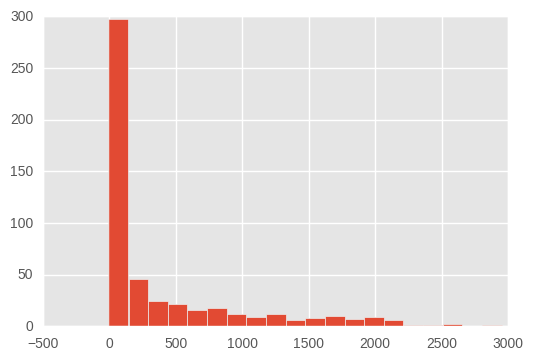

In [9]:
plot_data = ef.ea_days_after_discharge_death.values
plot_data = plot_data[~np.isnan(plot_data)]
plt.hist(plot_data, bins=20)
print(plot_data.min(), plot_data.max())
print(np.sum(plot_data < 0)) # only 324 out of 10k died before discharge???
print(np.sum(plot_data == 0)) # 2512 died at 0 minutes after discharge???
print(pd.Series(plot_data).describe())

In [10]:
day30_mortality = ef.ea_days_after_discharge_death <= 30

In [11]:
day30_mortality.value_counts()

False    1861
True      233
Name: ea_days_after_discharge_death, dtype: int64

In [12]:
ef['day30_mortality'] = day30_mortality

In [13]:
ef.groupby(['day30_mortality', 'mech_vent']).size().unstack()

mech_vent,0,1
day30_mortality,,
False,1490,371
True,93,140


In [14]:
ef.groupby(['day30_mortality', 'noninv_vent']).size().unstack()

noninv_vent,0,1
day30_mortality,,
False,128,1733
True,20,213


In [15]:
%%bash
cat ../resources/lv_systolic.txt

====-1
Hyperdynamic LVEF >75%
Hyperdynamic LVEF
Left ventricular systolic function is hyperdynamic (EF>75%)
Hyperdynamic left ventricular systolic function
Hyperdynamic LVEF (>75%)
====0
Overall normal LVEF (>55%)
Normal LV wall thickness, cavity size and regional/global systolic function (LVEF >55%)
Low normal LVEF
Normal LV wall thickness, cavity size, and systolic function (LVEF>55%)
Mild symmetric LVH with normal cavity size and regional/global systolic function (LVEF>55%)
Overall left ventricular systolic function is normal (LVEF>55%)
Normal LV wall thickness, cavity size, and global systolic function (LVEF>55%)
Left ventricular wall thickness, cavity size, and systolic function are normal (LVEF>55%)
Mild symmetric LVH with normal cavity size and systolic function (LVEF>55%)
Mild symmetric LVH with normal cavity size and global systolic function (LVEF>55%)
Overall left ventricular systolic function is low normal (LVEF 50-55%)
There is mild symmetric left ventricular hypertrophy wi

In [16]:
table = ef.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
table

ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,8,56,1208,195,65,30
True,1,34,135,19,11,14


In [17]:
table = ef.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
table /= table.sum(axis=0)
table ## severely depressed and hyperdynamic have increased likelihood of death

ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,0.888889,0.622222,0.899479,0.911215,0.855263,0.681818
True,0.111111,0.377778,0.100521,0.088785,0.144737,0.318182


In [18]:
table = ef.groupby(['day30_mortality', 'ex_congestive_heart_failure']).size().unstack()
table

ex_congestive_heart_failure,0,1
day30_mortality,,
False,1790,71
True,183,50


In [19]:
table = ef.groupby(['day30_mortality', 'ex_congestive_heart_failure']).size().unstack()
table /= table.sum(axis=0)
table

ex_congestive_heart_failure,0,1
day30_mortality,,
False,0.907248,0.586777
True,0.092752,0.413223


In [20]:
for name,group in ef.groupby('ex_congestive_heart_failure'):
    table = group.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
    #table /= table.sum(axis=0)
    print('Congestive heart failure =', name)
    display(table)

Congestive heart failure = 0


ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,8,53,1174,188,57,23
True,1,30,112,14,6,8


Congestive heart failure = 1


ea_lv_systolic,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,
False,3,34,7,8,7
True,4,23,5,5,6


In [21]:
for name,group in ef.groupby('ex_congestive_heart_failure'):
    table = group.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
    table /= table.sum(axis=0)
    print('Congestive heart failure =', name)
    display(table)

Congestive heart failure = 0


ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,0.888889,0.638554,0.912908,0.930693,0.904762,0.741935
True,0.111111,0.361446,0.087092,0.069307,0.095238,0.258065


Congestive heart failure = 1


ea_lv_systolic,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,
False,0.428571,0.596491,0.583333,0.615385,0.538462
True,0.571429,0.403509,0.416667,0.384615,0.461538


count     2034.000000
mean      1650.460729
std       2514.101023
min      -9407.500000
25%         30.788138
50%       1386.796876
75%       2866.357128
max      18224.959261
dtype: float64


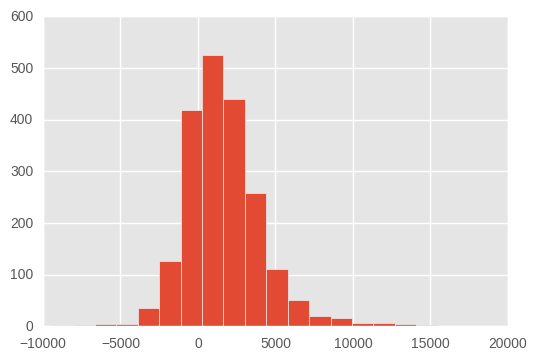

In [22]:
plot_data = ef.fl_day1_balance_ml.values
plot_data = plot_data[~np.isnan(plot_data)]
print(pd.Series(plot_data).describe())
_ = plt.hist(plot_data, bins=20)

 0.0     1343
 1.0      214
-1.0       90
 2.0       76
 3.0       44
-50.0       9
Name: ea_lv_systolic, dtype: int64

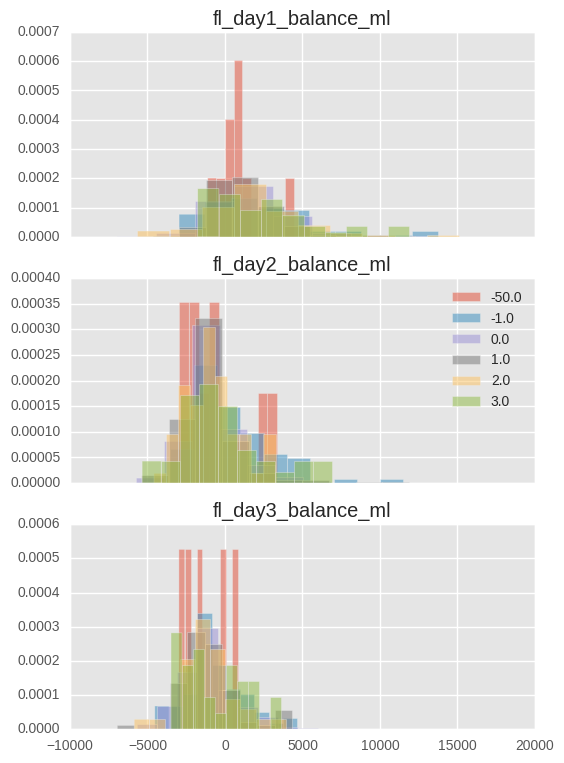

In [51]:
## if we group by echo lv systolic, what do the fluid distributions look like?
display(ef.ea_lv_systolic.value_counts())
fig, axs = plt.subplots(3, sharex=True, figsize=(6, 9))
for i,fluid_day in enumerate(['fl_day1_balance_ml', 'fl_day2_balance_ml', 'fl_day3_balance_ml']):
    ax = axs[i]
    for name,group in ef.groupby('ea_lv_systolic'):
        fluid = group[fluid_day].values.copy()
        # filter out less than -7 litres
        fluid[fluid < -7000] = np.nan
        fluid = fluid[~np.isnan(fluid)]
        ax.hist(fluid, alpha=0.5, label=str(name), normed=True)
    ax.set_title(fluid_day)
    if i == 1:
        ax.legend(loc='best')

In [169]:
to_plot = ef[['fl_day1_balance_ml', 'fl_day2_balance_ml', 'fl_day3_balance_ml']].stack().reset_index()
to_plot.columns = ['row_id', 'Day', 'Fluid balance (ml)']
to_plot.loc[to_plot['Day'] == 'fl_day1_balance_ml', 'Day'] = 1
to_plot.loc[to_plot['Day'] == 'fl_day2_balance_ml', 'Day'] = 2
to_plot.loc[to_plot['Day'] == 'fl_day3_balance_ml', 'Day'] = 3
to_plot = to_plot.loc[to_plot['Fluid balance (ml)'] >= -7000]
to_plot = pd.merge(to_plot, ef[['ea_lv_systolic']], left_on = 'row_id', right_index = True)
to_plot = pd.merge(to_plot, ef[['ex_congestive_heart_failure']], left_on = 'row_id', right_index = True)
to_plot = pd.merge(to_plot, ef[['day30_mortality']], left_on='row_id', right_index=True)
to_plot = pd.merge(to_plot, ef[['mech_vent']], left_on='row_id', right_index=True)

## Fluid management following echo by LV systolic

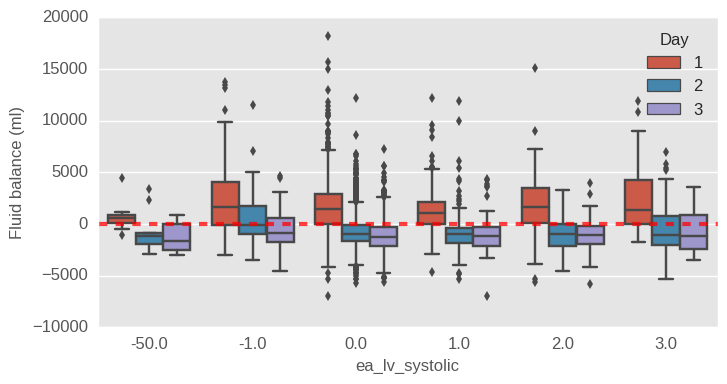

In [122]:
plt.figure(figsize=(8, 4))
sns.boxplot(data = to_plot, x = 'ea_lv_systolic', y = 'Fluid balance (ml)', hue = 'Day')
plt.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)

## Congestive heart failure changes fluid management depending on LV systolic

In [123]:
counts = ef.groupby('ex_congestive_heart_failure').apply(lambda x: x['ea_lv_systolic'].value_counts())
counts = counts.unstack().T
counts.index.name = 'ea_lv_systolic'
counts

ex_congestive_heart_failure,0,1
ea_lv_systolic,,
-50.0,9.0,NaN
-1.0,83.0,7.0
0.0,1286.0,57.0
1.0,202.0,12.0
2.0,63.0,13.0
3.0,31.0,13.0


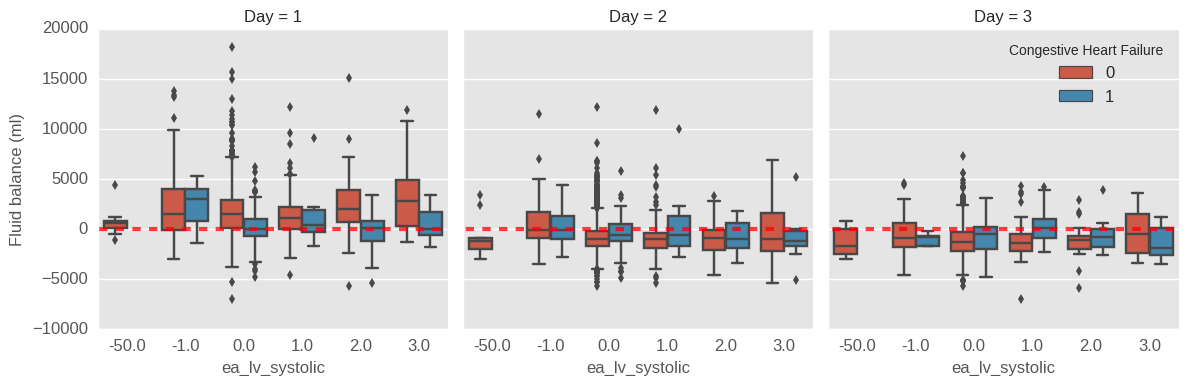

In [124]:
g  = sns.factorplot(data=to_plot, x='ea_lv_systolic', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='ex_congestive_heart_failure', col='Day')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Congestive Heart Failure')

## Fluid management by LV systolic and 30-day mortality

In [139]:
counts = ef.groupby('ea_lv_systolic').apply(lambda x: x['day30_mortality'].value_counts())
counts = counts.T
counts.index.name = 'day30_mortality'
counts

ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,8,56,1208,195,65,30
True,1,34,135,19,11,14


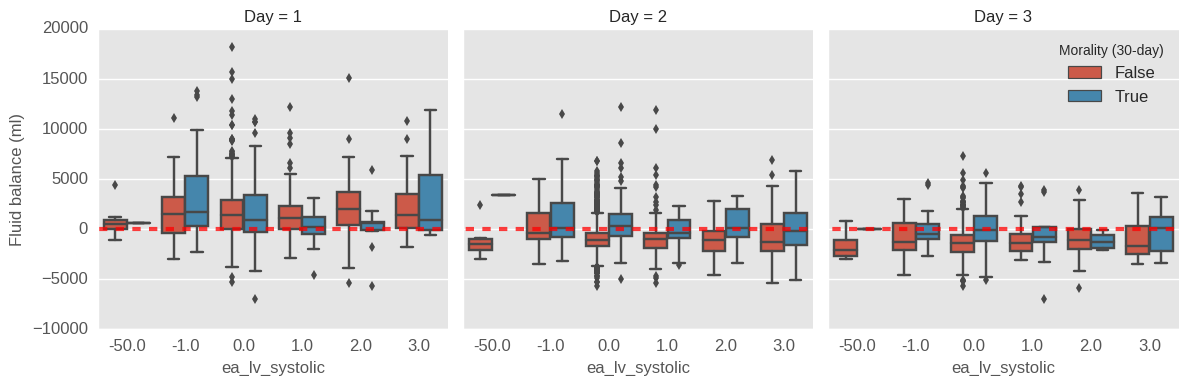

In [125]:
g  = sns.factorplot(data=to_plot, x='ea_lv_systolic', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

### Break down by congestive heart failure

In [129]:
counts = ef.groupby(['ex_congestive_heart_failure', 'ea_lv_systolic']).apply(lambda x: x['day30_mortality'].value_counts())
counts = counts.unstack().T
counts.index.name = 'day30_mortality'
counts

ex_congestive_heart_failure     0                                   1        \
ea_lv_systolic              -50.0 -1.0   0.0   1.0   2.0   3.0  -1.0   0.0    
day30_mortality                                                               
False                           8    53  1174   188    57    23     3    34   
True                            1    30   112    14     6     8     4    23   

ex_congestive_heart_failure                    
ea_lv_systolic               1.0   2.0   3.0   
day30_mortality                                
False                           7     8     7  
True                            5     5     6

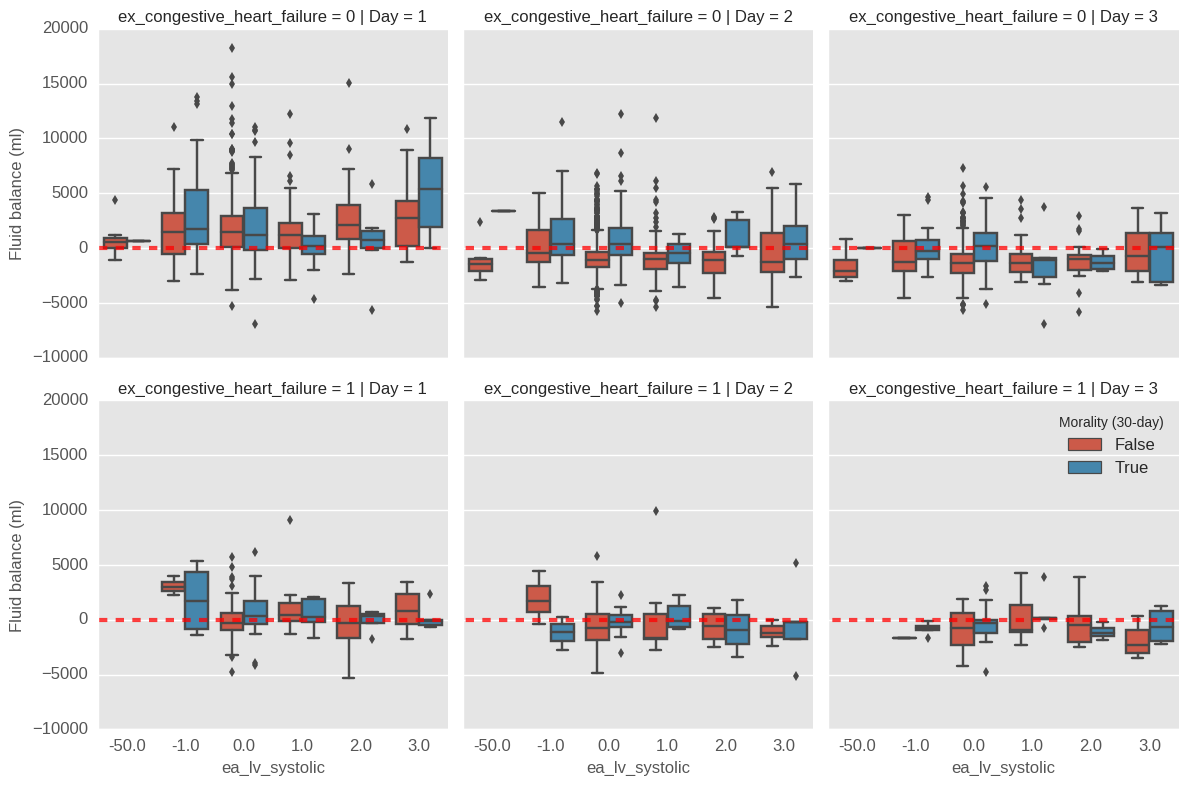

In [126]:
g  = sns.factorplot(data=to_plot, x='ea_lv_systolic', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day', row='ex_congestive_heart_failure')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

In [161]:
filter = (ef.ex_congestive_heart_failure == 0) & (ef.ea_lv_systolic == 3) & (ef.fl_day1_balance_ml >= -7000)
group_0 = ef.loc[filter & (ef.day30_mortality == False)].fl_day1_balance_ml
group_0 = group_0.dropna()
group_1 = ef.loc[filter & (ef.day30_mortality == True)].fl_day1_balance_ml
group_1 = group_1.dropna()

2654.95481492 3274.14766534
5413.41971921 4574.73149639


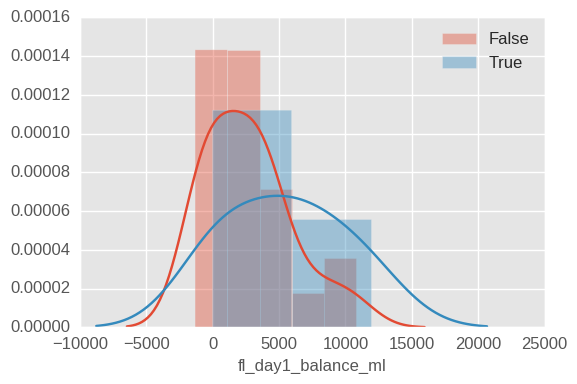

In [162]:
sns.distplot(group_0, label='False')
sns.distplot(group_1, label='True')
plt.legend()
print(group_0.mean(), group_0.std())
print(group_1.mean(), group_1.std())

In [163]:
from scipy.stats import ttest_ind
ttest_ind(group_0, group_1, equal_var=False)

Ttest_indResult(statistic=-1.387211601672891, pvalue=0.21176213234053839)

In [167]:
from scipy.stats import pearsonr
data = ef.loc[filter,['fl_day1_balance_ml', 'day30_mortality']].dropna()
pearsonr(data.fl_day1_balance_ml, data.day30_mortality)

(0.31003843308847068, 0.10167518169526461)

### Break down by mechanical ventilation

In [168]:
counts = ef.groupby(['mech_vent', 'ea_lv_systolic']).apply(lambda x: x['day30_mortality'].value_counts())
counts = counts.unstack().T
counts.index.name = 'day30_mortality'
counts

mech_vent           0                                     1               \
ea_lv_systolic  -50.0 -1.0    0.0    1.0   2.0   3.0  -50.0 -1.0    0.0    
day30_mortality                                                            
False             5.0  26.0  979.0  174.0  51.0  14.0   3.0  30.0  229.0   
True              NaN  19.0   51.0    6.0   4.0   6.0   1.0  15.0   84.0   

mech_vent                          
ea_lv_systolic   1.0   2.0   3.0   
day30_mortality                    
False            21.0  14.0  16.0  
True             13.0   7.0   8.0

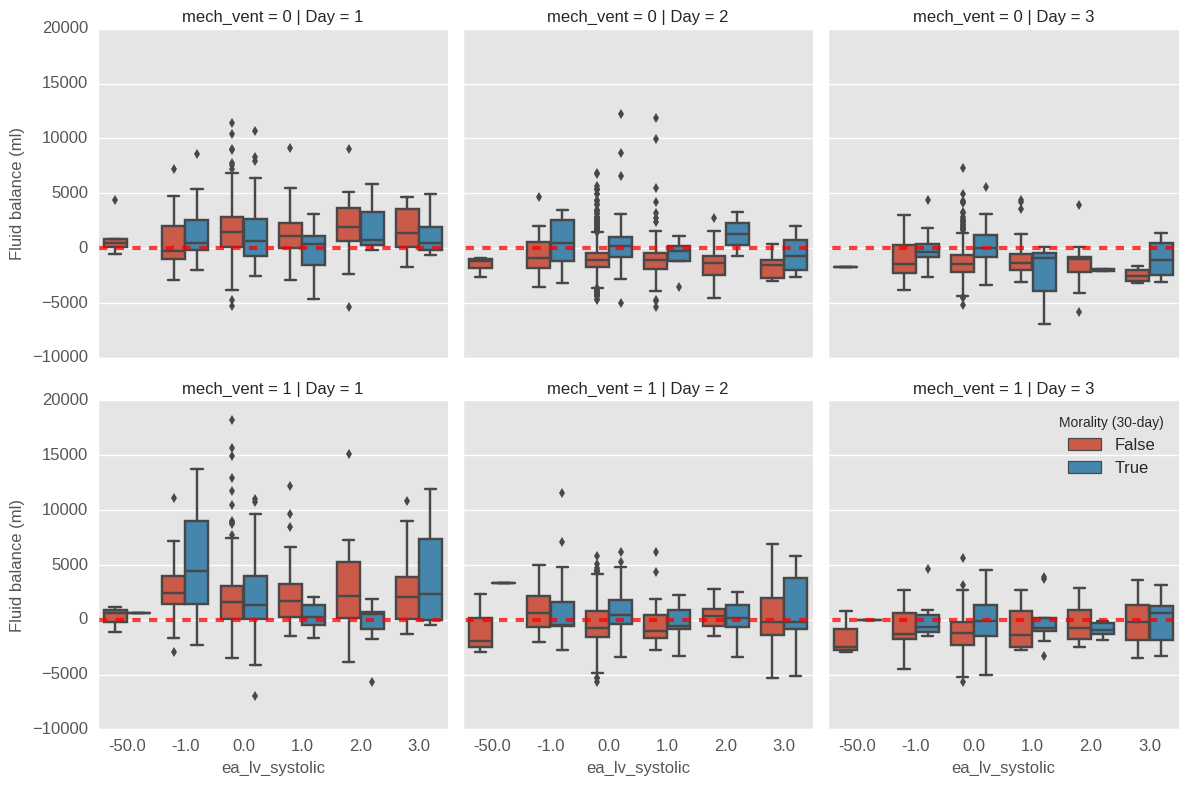

In [170]:
g  = sns.factorplot(data=to_plot, x='ea_lv_systolic', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day', row='mech_vent')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

### Calculate MDRD and breakdown fluid management

In [181]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age_at_intime/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [219]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    890
1    679
2    221
3    129
4    128
5     47
dtype: int64

In [201]:
counts = ef.groupby('day30_mortality').apply(lambda x: x['mdrd_discrete'].value_counts())
counts = counts.unstack()
display(counts)
counts /= counts.sum(axis=0)
counts

,5,4,3,2,1,0
day30_mortality,,,,,,
False,23,72,102,177,640,847
True,24,56,27,44,39,43


,5,4,3,2,1,0
day30_mortality,,,,,,
False,0.489362,0.5625,0.790698,0.800905,0.942563,0.951685
True,0.510638,0.4375,0.209302,0.199095,0.057437,0.048315


In [214]:
counts = ef.groupby('mdrd_discrete').apply(lambda x: x['ea_lv_systolic'].value_counts())
counts = counts.unstack().fillna(0)
#counts.columns.name = 'day30_mortality'
counts

,-50.0,-1.0,0.0,1.0,2.0,3.0
mdrd_discrete,,,,,,
5,0.0,7.0,28.0,5.0,2.0,1.0
4,2.0,19.0,69.0,15.0,7.0,5.0
3,1.0,14.0,72.0,13.0,8.0,2.0
2,1.0,13.0,134.0,29.0,5.0,10.0
1,0.0,25.0,438.0,59.0,27.0,16.0
0,5.0,12.0,602.0,93.0,27.0,10.0


In [205]:
to_plot = pd.merge(to_plot, ef[['mdrd_discrete']], left_on='row_id', right_index=True)

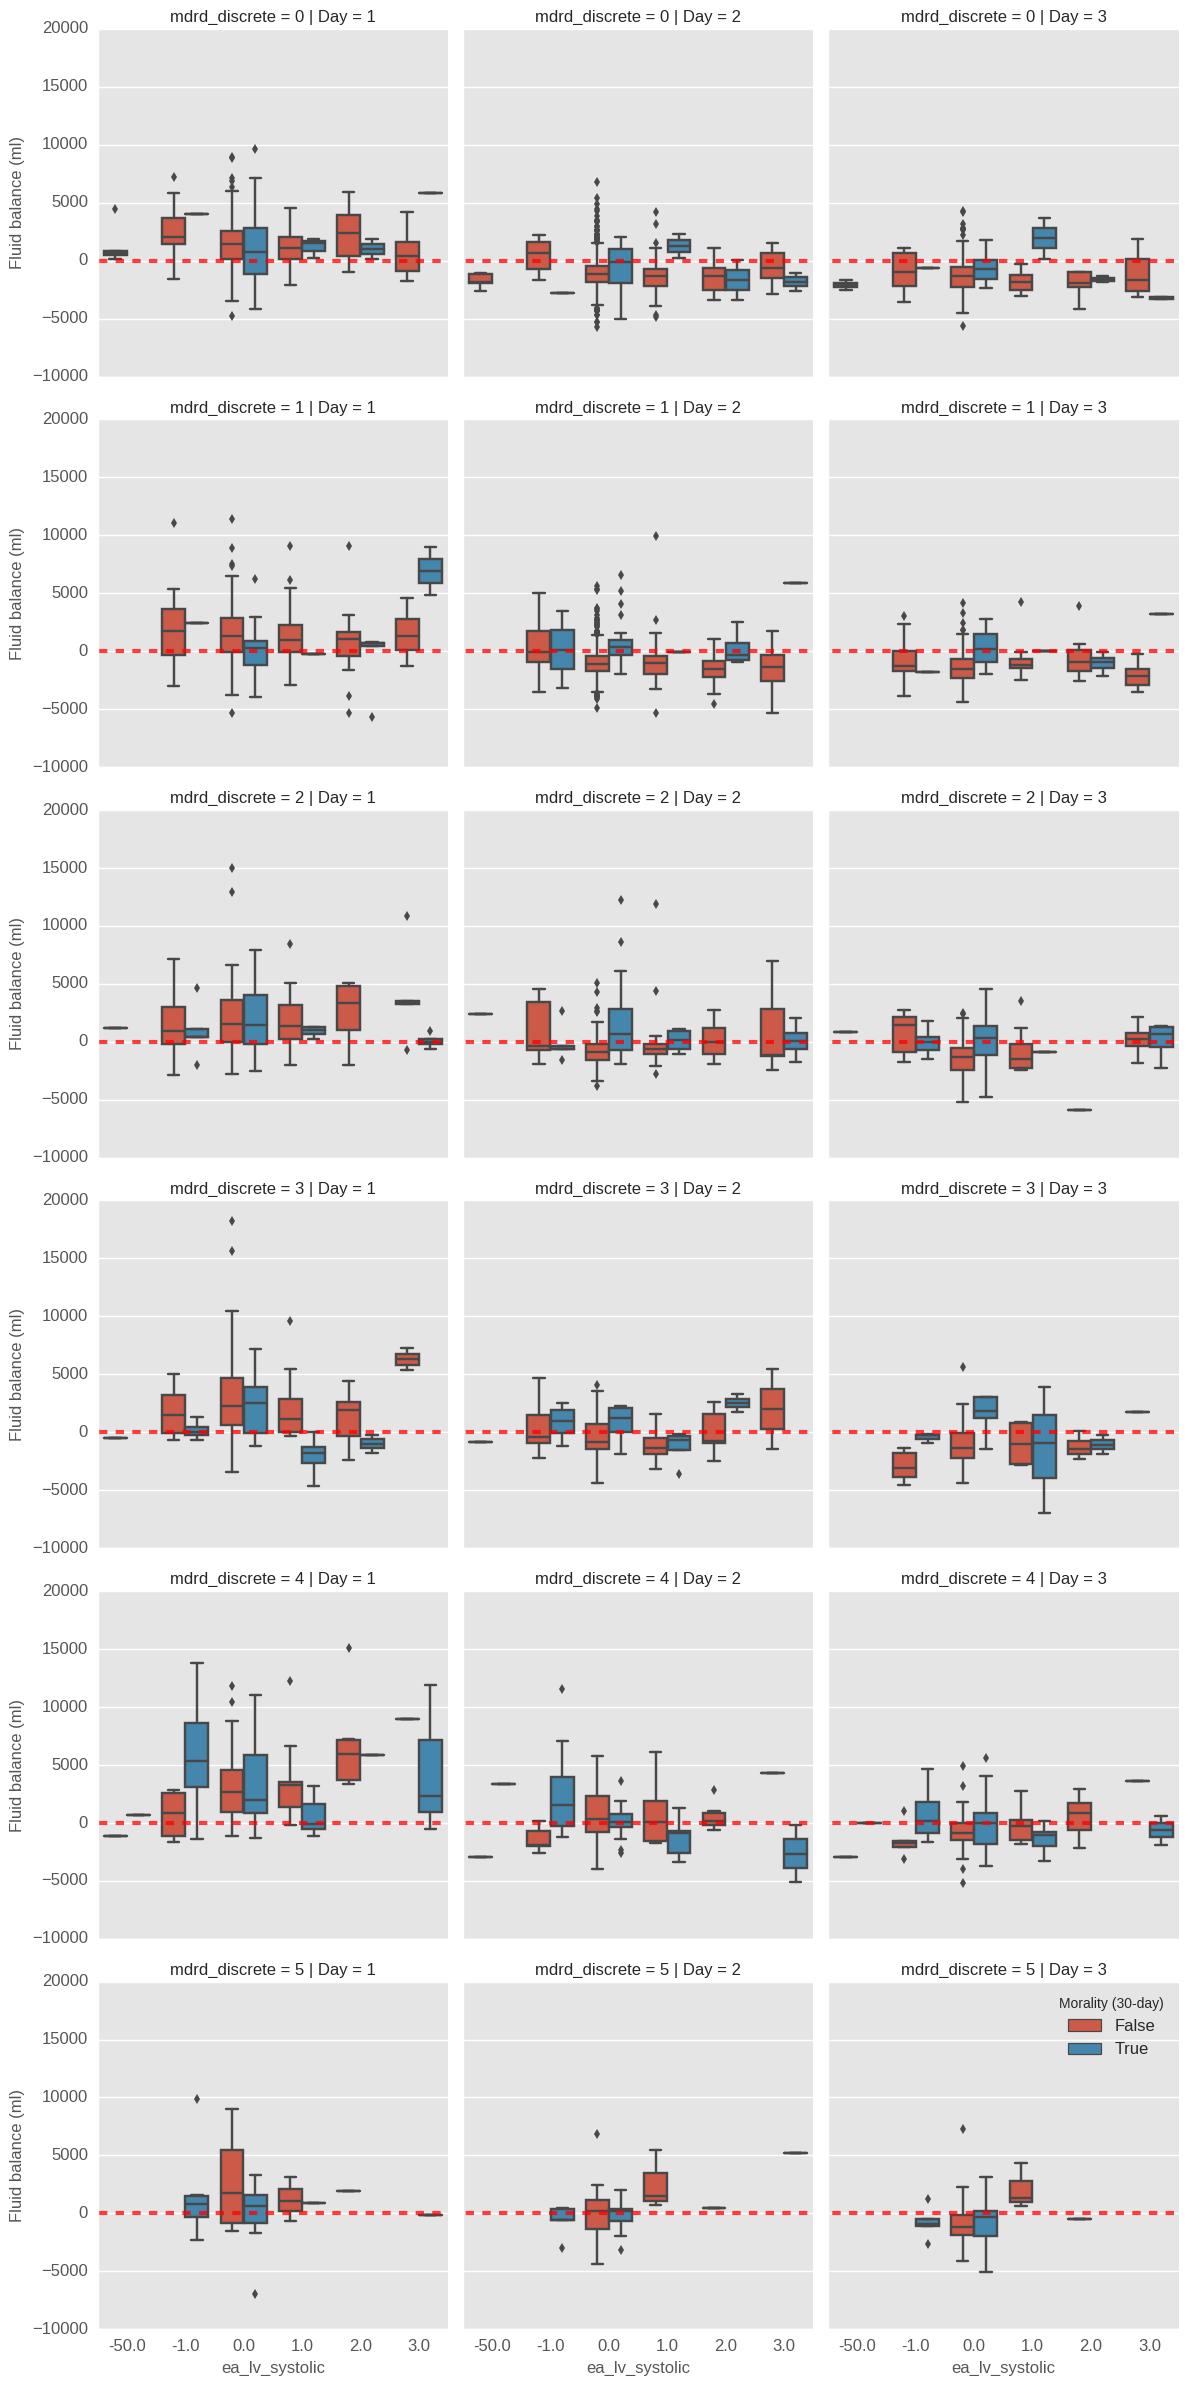

In [206]:
g  = sns.factorplot(data=to_plot, x='ea_lv_systolic', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day', row='mdrd_discrete')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

In [208]:
filter = (ef.mdrd_discrete == 1) & (ef.ea_lv_systolic == 3) & (ef.fl_day1_balance_ml >= -7000)
group_0 = ef.loc[filter & (ef.day30_mortality == False)].fl_day1_balance_ml
group_0 = group_0.dropna()
group_1 = ef.loc[filter & (ef.day30_mortality == True)].fl_day1_balance_ml
group_1 = group_1.dropna()

1466.46029287 1948.84404471
6915.52117303 2871.53069522


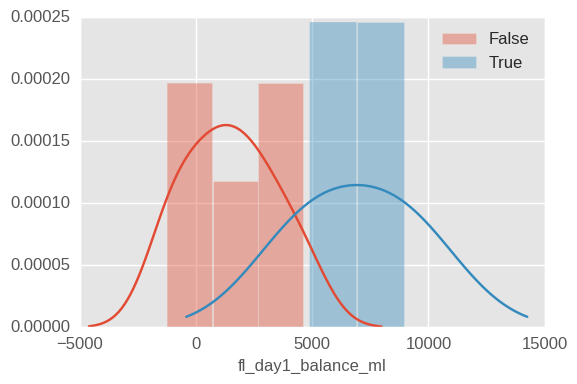

In [209]:
sns.distplot(group_0, label='False')
sns.distplot(group_1, label='True')
plt.legend()
print(group_0.mean(), group_0.std())
print(group_1.mean(), group_1.std())

In [213]:
from scipy.stats import ttest_ind
ttest_ind(group_0, group_1, equal_var=False)

Ttest_indResult(statistic=-2.5933218849235851, pvalue=0.20786336748664661)

In [211]:
from scipy.stats import pearsonr
data = ef.loc[filter,['fl_day1_balance_ml', 'day30_mortality']].dropna()
pearsonr(data.fl_day1_balance_ml, data.day30_mortality)

(0.69915401976227753, 0.00372527005333079)

## Classification of 30-day mortality using LV systolic, congestive heart failure, fluid balance, and MDRD

In [267]:
## form the feature and target vectors
def make_features(data):
    mdrd = data.mdrd
    age = data.age_at_intime/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender == 'F'
    lv_sys = pd.get_dummies(data.ea_lv_systolic, dummy_na=True)
    features = lv_sys
    features['mdrd'] = mdrd
    features['age'] = age
    features['gender'] = gender
    features['congestive_heart_failure'] = ef.ex_congestive_heart_failure
    features['mech_vent'] = ef.mech_vent
    features['fluid1'] = ef.fl_day1_balance_ml
    features['fluid2'] = ef.fl_day2_balance_ml
    ## too many NaN in fluid3, remove
    #features['fluid3'] = ef.fl_day3_balance_ml 
    return features

In [268]:
x = make_features(ef)
y = ef.day30_mortality

In [269]:
x.head()

,-50.0,-1.0,0.0,1.0,2.0,3.0,nan,mdrd,age,gender,congestive_heart_failure,mech_vent,fluid1,fluid2
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,111.600729,69.661764,False,0,0,1116.0,-693.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,111.911737,68.713292,False,0,0,2083.0,-1020.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,119.730128,76.711887,True,0,1,1630.0,-1463.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,107.992950,45.234315,True,0,0,1813.0,-424.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,29.245856,75.685489,True,1,1,2255.0,-360.5


In [270]:
filter = ~np.isnan(x.fluid1.values) & ~np.isnan(x.fluid2.values)
x = x.iloc[filter]
y = y.iloc[filter]

In [271]:
## split into train and test
I = np.random.permutation(len(x))
n = int(0.1*len(x))
x_train = x.iloc[I[n:]]
y_train = y.iloc[I[n:]]
x_test = x.iloc[I[:n]]
y_test = y.iloc[I[:n]]

In [272]:
print(y_test.mean())
print(y_train.mean())
print(y.mean())

0.0810810810811
0.102994011976
0.100808625337


In [273]:
from sklearn.ensemble import RandomForestClassifier

In [274]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [275]:
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.989820359281
0.897297297297


In [276]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.92      0.97      0.95       170
       True       0.17      0.07      0.10        15

avg / total       0.86      0.90      0.88       185



In [277]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['False', 'True'], index=['False', 'True'])
conf.index.name = 'Observed'
conf.columns.name = 'Predicted'
conf

Predicted,False,True
Observed,,
False,165,5
True,14,1


In [278]:
pd.DataFrame(pd.Series(model.feature_importances_, index=x.columns)).sort_values(0, ascending=False)

,0
mdrd,0.234016
age,0.190491
fluid1,0.190434
fluid2,0.186594
mech_vent,0.048649
congestive_heart_failure,0.037291
gender,0.030251
-1.0,0.026424
NaN,0.014575
0.0,0.013396


In [281]:
from sklearn.ensemble import GradientBoostingClassifier

In [282]:
model = GradientBoostingClassifier()
model.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [283]:
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.952694610778
0.924324324324


In [284]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.93      0.99      0.96       170
       True       0.60      0.20      0.30        15

avg / total       0.91      0.92      0.91       185



In [285]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['False', 'True'], index=['False', 'True'])
conf.index.name = 'Observed'
conf.columns.name = 'Predicted'
conf

Predicted,False,True
Observed,,
False,168,2
True,12,3


In [286]:
pd.DataFrame(pd.Series(model.feature_importances_, index=x.columns)).sort_values(0, ascending=False)

,0
mdrd,0.233145
fluid1,0.227958
fluid2,0.226741
age,0.183917
mech_vent,0.033653
-1.0,0.032346
congestive_heart_failure,0.028736
NaN,0.011598
1.0,0.007039
3.0,0.005704


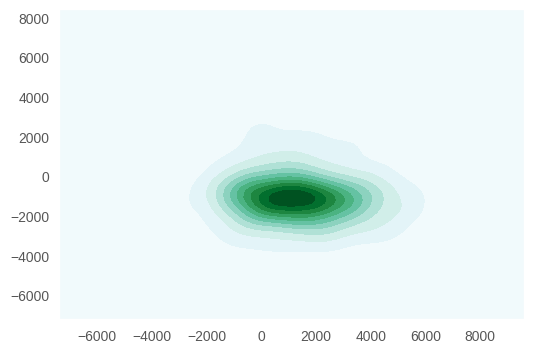

In [31]:
fluid1 = ef.fl_day1_balance_ml.values.copy()
fluid2 = ef.fl_day2_balance_ml.values.copy()
mask = np.isnan(fluid1) | np.isnan(fluid2)
mask |= (fluid1 < -7000) | (fluid2 < -7000) | (fluid1 > 8000) | (fluid2 > 8000)
fluid1 = fluid1[~mask]
fluid2 = fluid2[~mask]
sns.kdeplot(fluid1, fluid2, shade=True)

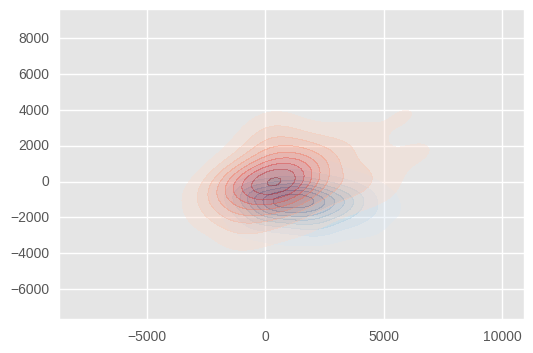

In [32]:
color = ['Blues', 'Reds']
i = 0
for name,group in ef.groupby('day30_mortality'):
    fluid1 = group.fl_day1_balance_ml.values.copy()
    fluid2 = group.fl_day2_balance_ml.values.copy()
    mask = np.isnan(fluid1) | np.isnan(fluid2)
    mask |= (fluid1 < -7000) | (fluid2 < -7000) | (fluid1 > 8000) | (fluid2 > 8000)
    fluid1 = fluid1[~mask]
    fluid2 = fluid2[~mask]
    sns.kdeplot(fluid1, fluid2, shade=True, label=str(name), cmap=color[i], lw=5, shade_lowest=False, alpha=0.33)
    i += 1